In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## 1. Image Segmentation Using Thresholding

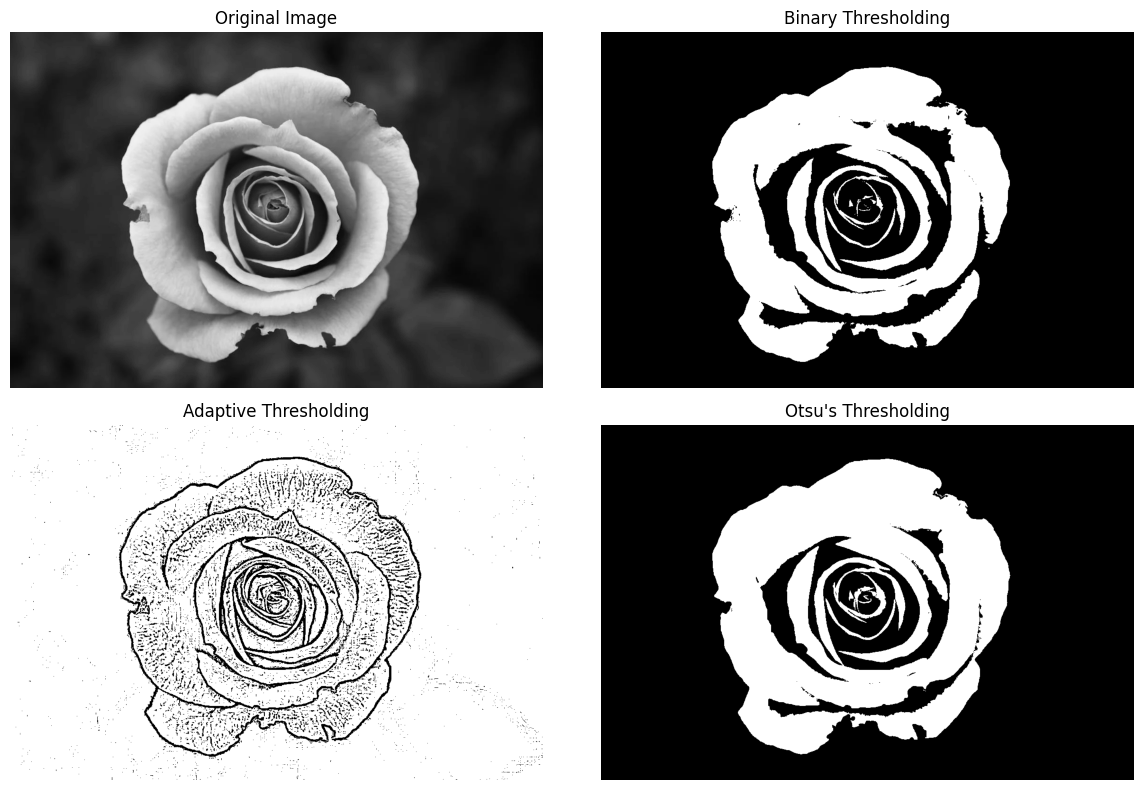

In [ ]:
gray_image = cv2.imread('img1.png', cv2.IMREAD_GRAYSCALE)
_, binary_thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
adaptive_thresh = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
_, otsu_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

titles = ['Original Image', 'Binary Thresholding', 'Adaptive Thresholding', "Otsu's Thresholding"]
images = [gray_image, binary_thresh, adaptive_thresh, otsu_thresh]

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

### Observations
- Binary Thresholding
    - Best for the images having uniform lighting and high contrast.
    - Poor performance on images with varying illumination or complex backgrounds.
    - It fails in the shadow regions in the above example.

- Adaptive Thresholding
    - Best for complex images having varying brightness or non-uniform illumination.
    - It may produce fragmented boundaries in the final image.
    - It captures fine details but introduces noise in the above example.

- Otsu's Thresholding
    - Best for the images having bimodal histograms.
    - Not suitable for images with uneven illumination or noisy images.
    - It produces clear distinction but may miss finer details in the above example.

So, we can conclude that the results of Otsu's Thresholding are better than the other two in the above example.

## 2. Line Detection Using Hough Transform

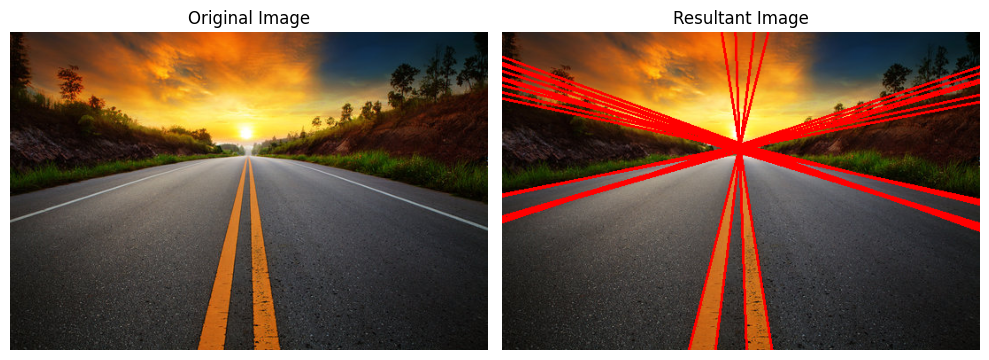

In [3]:
def detect_and_highlight_lines(image_path):
    original_image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    canny_thresh1 = 200
    canny_thresh2 = 200
    hough_thresh = 100
    
    # Apply Canny edge detection
    edges = cv2.Canny(gray_image, canny_thresh1, canny_thresh2)
    
    # Apply Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, hough_thresh)
    
    # Create a copy of the original image to draw the lines
    result_image = original_image.copy()
    
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(result_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title('Resultant Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

detect_and_highlight_lines('road.jpg')

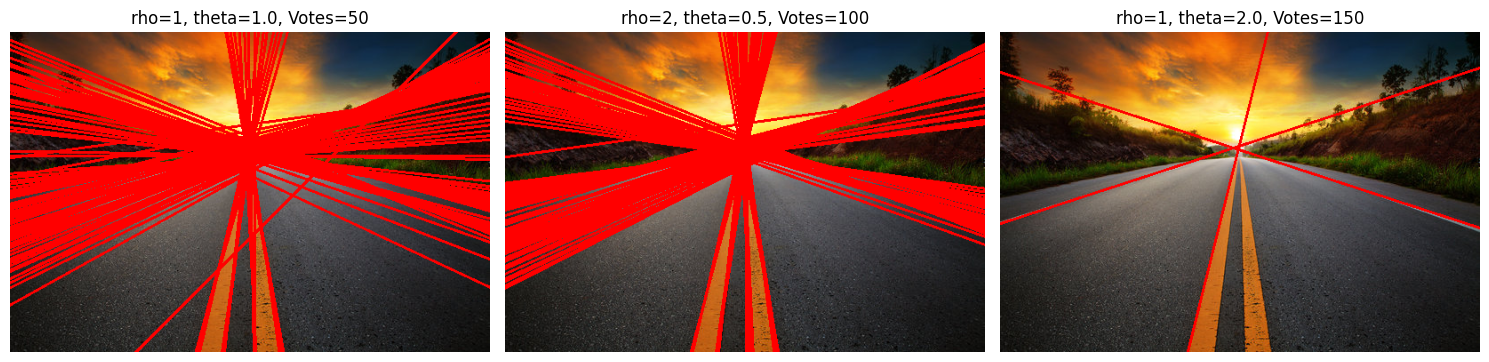

In [4]:
def experiment_hough_parameters(image_path, rho=1, theta=np.pi/180, hough_thresh=100, canny_thresh1=200, canny_thresh2=200):
    original_image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, canny_thresh1, canny_thresh2)

    # Hough Line Transform
    lines = cv2.HoughLines(edges, rho, theta, hough_thresh)
    result_image = original_image.copy()

    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(result_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return result_image

parameter_sets = [
    {'rho': 1, 'theta': np.pi/180, 'hough_thresh': 50},
    {'rho': 2, 'theta': np.pi/360, 'hough_thresh': 100},
    {'rho': 1, 'theta': np.pi/90, 'hough_thresh': 150},
]

plt.figure(figsize=(15, 10))
for i, params in enumerate(parameter_sets):
    processed = experiment_hough_parameters('road.jpg', **params)
    plt.subplot(1, len(parameter_sets), i + 1)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    title = f"rho={params['rho']}, theta={params['theta']*180/np.pi:.1f}, Votes={params['hough_thresh']}"
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Observations:

- Increasing rho (distance resolution) or theta (angular resolution) reduces sensitivity, resulting in fewer, more distinct lines being detected.
- Lower resolutions can capture broad features but may miss fine details.
- Raising the vote threshold filters out weaker lines, focusing only on the strongest candidates, which helps reduce clutter and improves clarity for prominent features.
- In the example, higher thresholds and resolutions produce cleaner outputs by emphasizing the most prominent road lines.

## 3. Circle Detection Using Hough Circle Transform

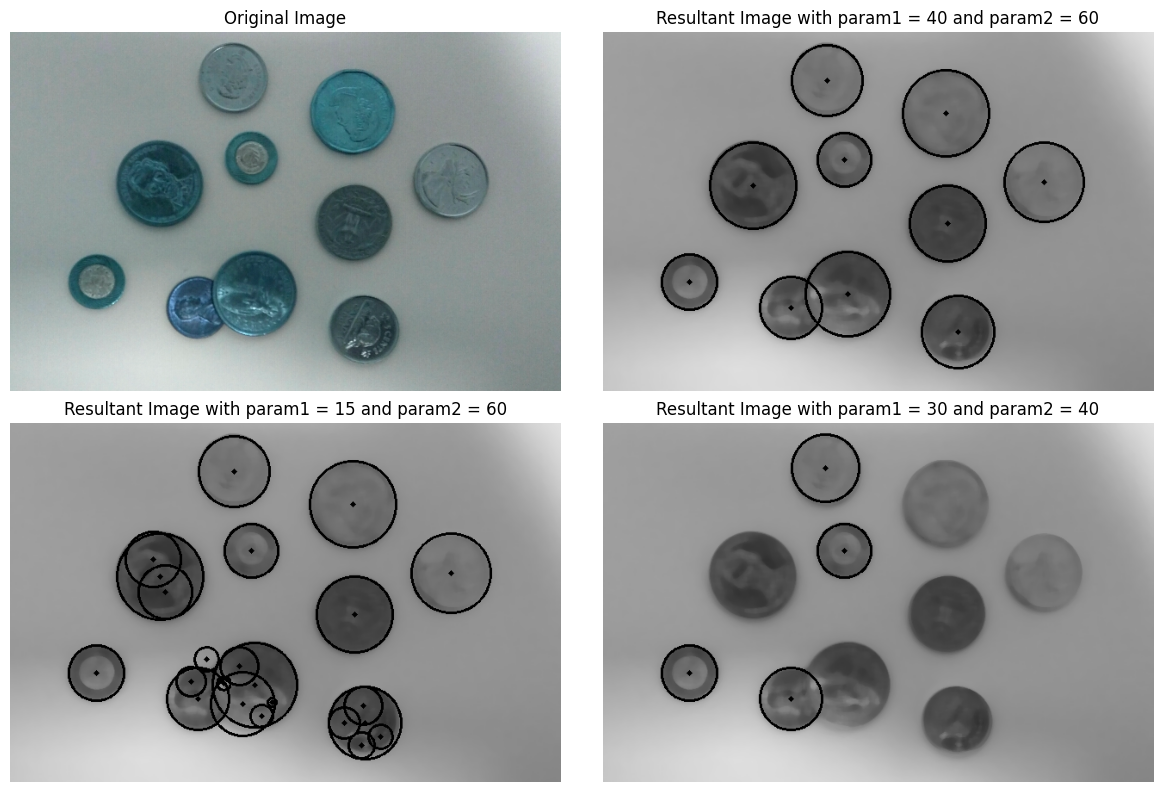

In [5]:
def detect_and_highlight_circles(image, accumulator_thresh, radius):
    final_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).copy()
    final_image = cv2.medianBlur(final_image, 9)
    circles = cv2.HoughCircles(final_image, cv2.HOUGH_GRADIENT, 1, 20, param1=60, param2=accumulator_thresh, minRadius=0, maxRadius=radius)

    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(final_image, (i[0], i[1]), i[2], (0, 255, 0), 2)
            cv2.circle(final_image, (i[0], i[1]), 1, (0, 0, 255), 3)
    return final_image

original_image = cv2.imread('./circles.jpg')
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(detect_and_highlight_circles(original_image, 40, 60), cv2.COLOR_BGR2RGB))
plt.title('Resultant Image with param1 = 40 and param2 = 60')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(detect_and_highlight_circles(original_image, 15, 60), cv2.COLOR_BGR2RGB))
plt.title('Resultant Image with param1 = 15 and param2 = 60')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(detect_and_highlight_circles(original_image, 30, 40), cv2.COLOR_BGR2RGB))
plt.title('Resultant Image with param1 = 30 and param2 = 40')
plt.axis('off')
plt.tight_layout()
plt.show()

### Observations
- Lowering the maximum radius value results in not detecting the circles with larger radii.
- Lowering the accumulator threshold value detects the unnecessary cirlces in the image.
- Also, very high value of accumulator threshold may not detect all the circles in the image.
- Thus, we need to choose a specific value of accumulator threshold and radii in order to detect all the required circles.

## 4. Harris Corner Detection

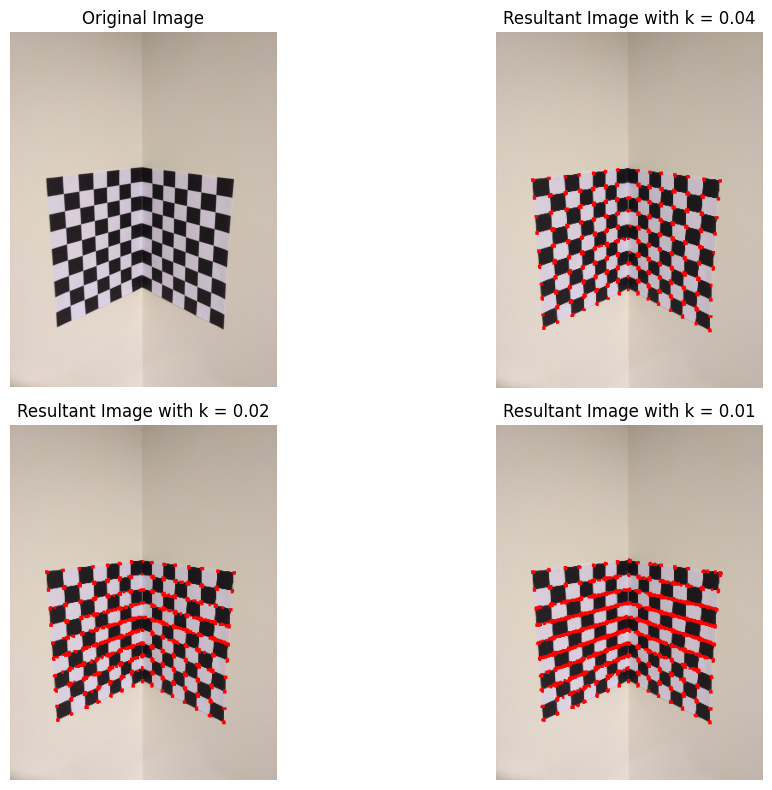

In [6]:
def Harris_Corners(img_path):
    img = cv2.imread(img_path)
    original_image = img.copy()
    result_img = cv2.resize(img, [int(img.shape[1]/10), int(img.shape[0]/10)])
    result_img1 = result_img.copy()
    result_img2 = result_img.copy()
    gray = np.float32(cv2.cvtColor(result_img, cv2.COLOR_BGR2GRAY))
    dst = cv2.cornerHarris(gray, 2, 3, k=0.04)
    dst = cv2.dilate(dst, None)
    result_img[dst > 0.01 * dst.max()] = [0, 0, 255]
    
    gray = np.float32(cv2.cvtColor(result_img1, cv2.COLOR_BGR2GRAY))
    dst = cv2.cornerHarris(gray, 2, 3, k=0.02)
    dst = cv2.dilate(dst, None)
    result_img1[dst > 0.01 * dst.max()] = [0, 0, 255]
    
    gray = np.float32(cv2.cvtColor(result_img2, cv2.COLOR_BGR2GRAY))
    dst = cv2.cornerHarris(gray, 2, 3, k=0.01)
    dst = cv2.dilate(dst, None)
    result_img2[dst > 0.01 * dst.max()] = [0, 0, 255]
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title('Resultant Image with k = 0.04')
    plt.axis('off')
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(result_img1, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title('Resultant Image with k = 0.02')
    plt.axis('off')
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(result_img2, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title('Resultant Image with k = 0.01')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Harris_Corners('calib-object.jpg')

###  Observations
- The sensitivity parameter k influences the balance between edge and corner detection.
- For higher k values fewer corners are detected, focusing on strong corners while ignoring weaker ones.
- As k decreases, the algorithm becomes more sensitive, detecting more features while including the weaker corners.
- This demonstrates that choosing k involves a trade-off between robustness and sensitivity to corner-like features.The sensitivity parameter k in the Harris Corner Detection function influences the balance between edge and corner detection. As seen in the results:

For higher k values (e.g., k=0.04), fewer corners are detected, focusing on strong corners while ignoring weaker ones.
As k decreases (e.g., k=0.01), the algorithm becomes more sensitive, detecting more features, including weaker corners, but potentially introducing false positives.
This demonstrates that choosing k involves a trade-off between robustness and sensitivity to corner-like features.

## 5. Short Theory

The Hough Transform is a technique used for detecting shapes in images, primarily lines and circles, but it operates differently for each shape due to variations in parameter space and computational complexity.

When detecting lines, the Hough Transform utilizes a two-dimensional parameter space defined by (rho, theta), where rho is the distance from the origin to the line and theta is the angle of the line. Each point in the image contributes to a sinusoidal curve in this space, resulting in intersections that indicate potential lines. The computational complexity is relatively low, as it involves accumulating votes in this two-dimensional space.

In contrast, detecting circles involves a three-dimensional parameter space defined by (a, b, r) where (a, b) are the circle's center coordinates and r is its radius. This increases both the memory requirements and computational complexity significantly because every pixel must vote in a three-dimensional accumulator, making it more resource-intensive than line detection.